# Crzay World

There are 2 functions that change the engineer of Grid World:

## 1- grid.updtade_rewards()
         
after each episode change the palce of trap randomly
        
## 2- grid.off_on_rewards(it) --> not answering on SARSA
alternately in episodes, change value of trap block:

0: for even iteration

or

step_cost: for odd iteration

In [1]:
class CrazyGrid:
    def __init__(self, rows, cols, start):
        self.rows = rows
        self.cols = cols
        self.i = start[0]
        self.j = start[1]

    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions

    def set_points(self, step_cost, trap_point, trap):
        self.step_cost = step_cost
        self.trap_point = trap_point
        self.trap = trap

    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]

    def current_state(self):
        return (self.i, self.j)

    def is_terminal(self, s):
        return s not in self.actions

    def get_next_state(self, s, a):
        i, j = s[0], s[1]
        if a in self.actions[(i, j)]:
            if a == 'S':
                return i, j
            if a == 'U':
                i -= 1
            elif a == 'D':
                i += 1
            elif a == 'R':
                j += 1
            elif a == 'L':
                j -= 1
        return i, j

    def move(self, action):
        if action in self.actions[(self.i, self.j)]:
            if action == 'S':
                pass
            if action == 'U':
                self.i -= 1
            elif action == 'D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
        return self.rewards.get((self.i, self.j), 0)

    def game_over(self):
        return (self.i, self.j) not in self.actions

    def all_states(self):
        return set(self.actions.keys()) | set(self.rewards.keys())

    def updtade_rewards(self):
        grid.rewards[self.trap] = self.step_cost
        states = list(self.actions.keys())
        negative_idx = np.random.choice(len(states))
        grid.rewards.update({states[negative_idx]: self.trap_point})
        self.trap = states[negative_idx]

    def off_on_rewards(self, it):
        if it % 2 == 0:
            grid.rewards[self.trap] = self.step_cost
        else:
            grid.rewards[self.trap] = self.trap_point



In [2]:
def crazy_grid(step_cost = -0.1, trap_point= -10, trap = (3, 2)):
    game = CrazyGrid(5, 5, (0, 0))
    rewards = {(3, 4): 1}
    actions = {
        (0, 0): ('D', 'R', 'S'),
        (1, 0): ('U', 'D', 'S'),
        (2, 0): ('U', 'R', 'S'),  # 'D',
        # (3, 0): ('U', 'D', 'S'), # block for making a specific path
        (4, 0): ('R', 'S'),  # 'U',

        (0, 1): ('L', 'R', 'S'),
        # (1, 1): ('U', 'D', 'R'),
        (2, 1): ('L', 'R', 'S'),
        # (3, 1): ('L', 'R'),
        (4, 1): ('L', 'R', 'S'),

        (0, 2): ('D', 'L', 'S'),
        (1, 2): ('D', 'U', 'R', 'S'),
        (2, 2): ('D', 'U', 'L', 'S'),
        (3, 2): ('D', 'U', 'S'),   # trap
        (4, 2): ('U', 'L', 'R', 'S'),

        # (0, 3): ('D', 'L'),
        (1, 3): ('R', 'L', 'S'),
        # (2, 3): ('D', 'U'),
        (3, 3): ('R', 'L', 'D', 'S'),
        (4, 3): ('U', 'R', 'L', 'S'),

        (0, 4): ('D', 'S'),
        (1, 4): ('U', 'L', 'S'),
        # (2, 4): ('D', 'U', 'L', 'S'),
        # (3, 4): ('D'),  # terminal
        (4, 4): ('U', 'L', 'S'),
    }

    game.set(rewards, actions)
    game.set_points(step_cost, trap_point, trap) 
    
    visitable_states = actions.keys()
    for s in visitable_states:
        game.rewards[s] = step_cost

    game.rewards[trap] = trap_point
    return game

# Define Extra functions

In [3]:
def print_values(V, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            v = V.get((i, j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")  # -ve sign takes up an extra space
        print("")


def print_policy(P, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            a = P.get((i, j), ' ')
            print("  %s  |" % a, end="")
        print("")
        
def print_world(g):
    for i in range(g.rows):
        print("--------------------------------------------------")
        for j in range(g.cols):
            if (i, j) == (0, 0):
                print("  Start  |", end="")
            elif (i, j) == (3, 2):
                print("  Trap   |", end="")
            elif (i, j) == (3, 4):
                print("  Term.  |", end="")
            elif (i, j) not in g.actions.keys():
                print("  Wall   |", end="")
            else:              
                print("         |", end="")
        print("")

The random_action used in td0_prediction

In [4]:
def random_action(a, eps=0.1):
    # we'll use epsilon-soft to ensure all states are visited
    # what happens if you don't do this? i.e. eps=0
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [5]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    # put this into a function since we are using it so often
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

# Find Optimal Policy For Crazy Grid World      

In [6]:
import numpy as np
import matplotlib.pyplot as plt

GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R', 'S')

# 1- grid.updtade_rewards() 

first episode of grid world:
--------------------------------------------------
  Start  |         |         |  Wall   |         |
--------------------------------------------------
         |  Wall   |         |         |         |
--------------------------------------------------
         |         |         |  Wall   |  Wall   |
--------------------------------------------------
  Wall   |  Wall   |  Trap   |         |  Term.  |
--------------------------------------------------
         |         |         |         |         |
rewards:
---------------------------
-0.10|-0.10|-0.10| 0.00|-0.10|
---------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
---------------------------
-0.10|-0.10|-0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00|-10.00|-0.10| 1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|


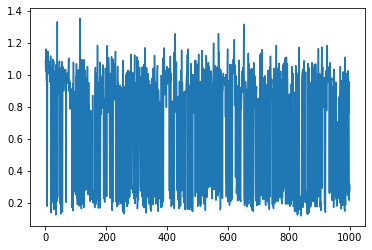

update counts:
---------------------------
 0.05| 0.05| 0.05| 0.00| 0.03|
---------------------------
 0.08| 0.00| 0.04| 0.03| 0.03|
---------------------------
 0.14| 0.12| 0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.09| 0.02| 0.00|
---------------------------
 0.01| 0.02| 0.07| 0.05| 0.03|
rewards:
---------------------------
-0.10|-10.00|-0.10| 0.00|-0.10|
---------------------------
-0.10| 0.00|-0.10|-0.10|-0.10|
---------------------------
-0.10|-0.10|-0.10| 0.00| 0.00|
---------------------------
 0.00| 0.00|-0.10|-0.10| 1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|-0.10|
values:
---------------------------
-5.27|-5.27|-4.37| 0.00|-4.89|
---------------------------
-4.91| 0.00|-3.91|-4.39|-4.85|
---------------------------
-4.04|-3.63|-2.78| 0.00| 0.00|
---------------------------
 0.00| 0.00|-1.95| 1.00| 0.00|
---------------------------
-2.57|-1.91|-0.98|-0.23| 1.00|
policy:
---------------------------
  U  |  R  |  D  |     |  D  |
---------------

In [7]:
if __name__ == '__main__':
    grid = crazy_grid()
    print("first episode of grid world:")
    print_world(grid)
    print("rewards:")
    print_values(grid.rewards, grid)

    # no policy initialization, we will derive our policy from most recent Q
    # initialize Q(s,a)
    Q = {}
    states = grid.all_states()
    for s in states:
        Q[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            Q[s][a] = 0

    update_counts = {}
    update_counts_sa = {}
    for s in states:
        update_counts_sa[s] = {}
        for a in ALL_POSSIBLE_ACTIONS:
            update_counts_sa[s][a] = 1.0

    t = 1.0
    deltas = []
    for it in range(1000):
        if it % 100 == 0:
            t += 1e-2
        s = (2, 0)  # start state
        grid.set_state(s)
        a = max_dict(Q[s])[0]
        a = random_action(a, eps=0.5 / t)
        biggest_change = 0
        
        while not grid.game_over():
            r = grid.move(a)
            s2 = grid.current_state()

            # we need the next action as well since Q(s,a) depends on Q(s',a')
            # if s2 not in policy then it's a terminal state, all Q are 0
            a2 = max_dict(Q[s2])[0]
            a2 = random_action(a2, eps=0.5 / t)  # epsilon-greedy

            # we will update Q(s,a) AS we experience the episode
            old_qsa = Q[s][a]
            Q[s][a] = Q[s][a] + ALPHA * (r + GAMMA * Q[s2][a2] - Q[s][a])
            biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

            # we would like to know how often Q(s) has been updated too
            update_counts[s] = update_counts.get(s, 0) + 1

            # next state becomes current state
            s = s2
            a = a2
            grid.updtade_rewards()
            #grid.off_on_rewards(it)

        deltas.append(biggest_change)

    plt.plot(deltas)
    plt.show()

    # determine the policy from Q*
    # find V* from Q*
    policy = {}
    V = {}
    for s in grid.actions.keys():
        a, max_q = max_dict(Q[s])
        policy[s] = a
        V[s] = max_q
    
    # what's the proportion of time we spend updating each part of Q?
    print("update counts:")
    total = np.sum(list(update_counts.values()))
    for k, v in update_counts.items():
        update_counts[k] = float(v) / total
    print_values(update_counts, grid)
    print("rewards:")
    print_values(grid.rewards, grid)
    print("values:")
    print_values(V, grid)
    print("policy:")
    print_policy(policy, grid)



# 2- grid.off_on_rewards(it)